# PURE

Periodic User Representation Extraction

In [1]:
from pure import *

# Data Preparation

## Load Data & Info

In [15]:
df_2015 = pd.read_csv('info/active_users.2015.csv', index_col=False, parse_dates=['exerciseDate', 'startTime'])
df_2016 = pd.read_csv('info/active_users.2016.csv', index_col=False, parse_dates=['exerciseDate', 'startTime'])

In [16]:
df = pd.concat([df_2015, df_2016])

In [17]:
print('{} samples'.format(len(df)))
print('{} distinct users'.format(len(df['userId'].unique())))

378203 samples
1614 distinct users


In [18]:
with open('info/samples.health_state_prediction.train.json', 'r') as f:
    select_context = json.load(f)

## Select Data

In [33]:
df['valid'] = [((str(u) in select_context) and (str(d)[:7] in select_context[str(u)])) \
               for u,d in zip(df['userId'], df['exerciseDate'])]

In [34]:
df['valid'].value_counts()

False    364966
True      13237
Name: valid, dtype: int64

In [35]:
df = df[df['valid'] == True]

## Refine Data

In [36]:
df.isnull().sum()

exerciseID         0
userId             0
exerciseClassId    0
velocity           0
duration           0
distance           0
calorie            0
startTime          0
exerciseDate       0
valid              0
dtype: int64

In [37]:
df = df.dropna(subset=['startTime', 'exerciseDate'])
print('{} samples'.format(len(df)))

13237 samples


In [9]:
def prepare_data(df):
    time_list = ['morning', 'afternoon', 'evening', 'night']
    time_dic = [time_list[3]]*6 + [time_list[0]]*6 + [time_list[1]]*6 + [time_list[2]]*6
    
    df['exerciseDate'] = [datetime(dt.year, dt.month, dt.day) for dt in df['startTime']]
    df['exerciseTime'] = [time_dic[x.hour] for x in df['startTime']]
    df['isExercise'] = [1 for x in df['startTime']]
    df['weekday'] = [x.weekday() for x in df['exerciseDate']]
    df['distance'] = df['distance'].fillna(value=0)
    df['exerciseClassId'] = list(map(lambda x: x if x!=11 else None, df['exerciseClassId']))
    return df

In [39]:
df = prepare_data(df)

## Save Data

In [40]:
df.to_csv('health_state_prediction/saved/exercise_info.train.csv', index=False)

# Training Process

## 0. Load Data

In [4]:
exercise_records = pd.read_csv('health_state_prediction/saved/exercise_info.train.csv', 
                               parse_dates=['exerciseDate', 'startTime'])

In [5]:
user_list = exercise_records['userId'].unique().tolist()
len(user_list), len(exercise_records)

(108, 13237)

In [6]:
exercise_records.isnull().sum()

exerciseID           0
userId               0
exerciseClassId    222
velocity             0
duration             0
distance             0
calorie              0
startTime            0
exerciseDate         0
valid                0
exerciseTime         0
isExercise           0
weekday              0
dtype: int64

In [7]:
exercise_records.head(3)

,exerciseID,userId,exerciseClassId,velocity,duration,distance,calorie,startTime,exerciseDate,valid,exerciseTime,isExercise,weekday
0,198732,10003,2.0,14.8,8880,36.5,1745,2015-11-01 10:50:39,2015-11-01,True,morning,1,6
1,198758,10003,9.0,0.0,847,0.0,100,2015-11-01 14:34:02,2015-11-01,True,afternoon,1,6
2,198771,10003,9.0,0.0,1169,0.0,95,2015-11-01 14:55:51,2015-11-01,True,afternoon,1,6


## 0. Create Module

In [10]:
uem = PURE(discretization_bin_count=20, pattern_mining_measure='PFPM', 
           clustering_distance_metric='jaccard', clustering_affinity='average')

In [11]:
uem.set_mode('train')

## 1. Transaction Construction

Prepare output directory

In [12]:
!rm -rf health_state_prediction/data/input
!mkdir health_state_prediction/data/input

Discretization and preprocessing for preparing exercise records

In [13]:
exercise_records = uem.preprocess_exercise_records(exercise_records)

Convert from exercise records to exercise transactions

In [14]:
exercise_transactions = uem.construct_exercise_transactions(user_list, exercise_records, 
                                                            output_path='health_state_prediction/data/input/')

Processing user 10428    : 100%|██████████| 108/108 [00:02<00:00, 40.81it/s]


In [12]:
import json
with open('health_state_prediction/saved/exercise_transactions.json', 'w') as f:
    json.dump(exercise_transactions, f)

## 2. Pattern Extraction

Prepare output directory

In [16]:
!rm -rf health_state_prediction/data/output
!mkdir health_state_prediction/data/output

Mining Periodic Frequent Patterns using the PFPM algorithm

In [10]:
import json
with open('health_state_prediction/saved/exercise_transactions.json', 'r') as f:
    exercise_transactions = json.load(f)

In [18]:
exercise_patterns = uem.extract_exercise_patterns(exercise_transactions, 
                                                  output_path='health_state_prediction/data/output/', 
                                                  file_size_limit=10*10**9, 
                                                  args={'minper':0, 'maxper':10, 'minavgper':0, 'maxavgper':7})

Processing file data/input/10428.2016-07.txt : 100%|██████████| 433/433 [13:14<00:00,  5.04it/s]  


In [8]:
import json
with open('health_state_prediction/saved/exercise_patterns.json', 'w') as f:
    json.dump(exercise_patterns, f)

## 3. Pattern Clustering

In [3]:
import json
with open('health_state_prediction/saved/exercise_patterns.json', 'r') as f:
    exercise_patterns = json.load(f)

**Step 1.** Fit a pattern indexer

In [21]:
uem.fit_pattern_indexer(exercise_patterns, occur_threshold=2, is_sqlite_solver=False)

Processing file data/output/10003.2016-01.txt:   1%|          | 3/433 [00:00<00:15, 27.74it/s]

No such file or directory: "data/output/10003.2016-03.txt"


Processing file data/output/10428.2016-07.txt: 100%|██████████| 433/433 [00:23<00:00, 18.05it/s]


24102404 unique patterns are found
24091142 patterns are removed from the white list


**Step 2.** Generate pattern vectors

In [4]:
info, pattern_vectors = uem.prepare_pattern_vectors(exercise_patterns, ret_info=True)

Processing file health_state_prediction/data/output/10003.2016-01.txt :   1%|          | 3/433 [00:00<01:45,  4.08it/s]

No such file or directory: "health_state_prediction/data/output/10003.2016-03.txt"


Processing file health_state_prediction/data/output/10428.2016-07.txt : 100%|██████████| 433/433 [00:52<00:00,  8.19it/s]


_Save raw exercise patterns..._

In [21]:
info = info[['userID', 'time_window']]
for i in range(uem.pattern_idxer.size):
    info['pattern_{}'.format(i)] = [ptn[i] for ptn in pattern_vectors]
info.to_csv('health_state_prediction/data/exercise_patterns.train.csv', index=False)

/home/amy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


**Step 3.** Compute linkage matrix

Processing file data/output/10003.2016-01.txt :   1%|          | 3/433 [00:00<00:24, 17.46it/s]

No such file or directory: "data/output/10003.2016-03.txt"


Processing file data/output/10428.2016-07.txt : 100%|██████████| 433/433 [00:42<00:00, 10.29it/s]

Number of tasks: 432



[Parallel(n_jobs=-5)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-5)]: Done  59 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-5)]: Done 432 out of 432 | elapsed:    2.4s finished
/home/amy/pure/utils/pattern_clustering.py:28: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  self.linkage_matrix = linkage(distance_matrix, self.affinity)


==> Computing Linakage Matrix...
Done.


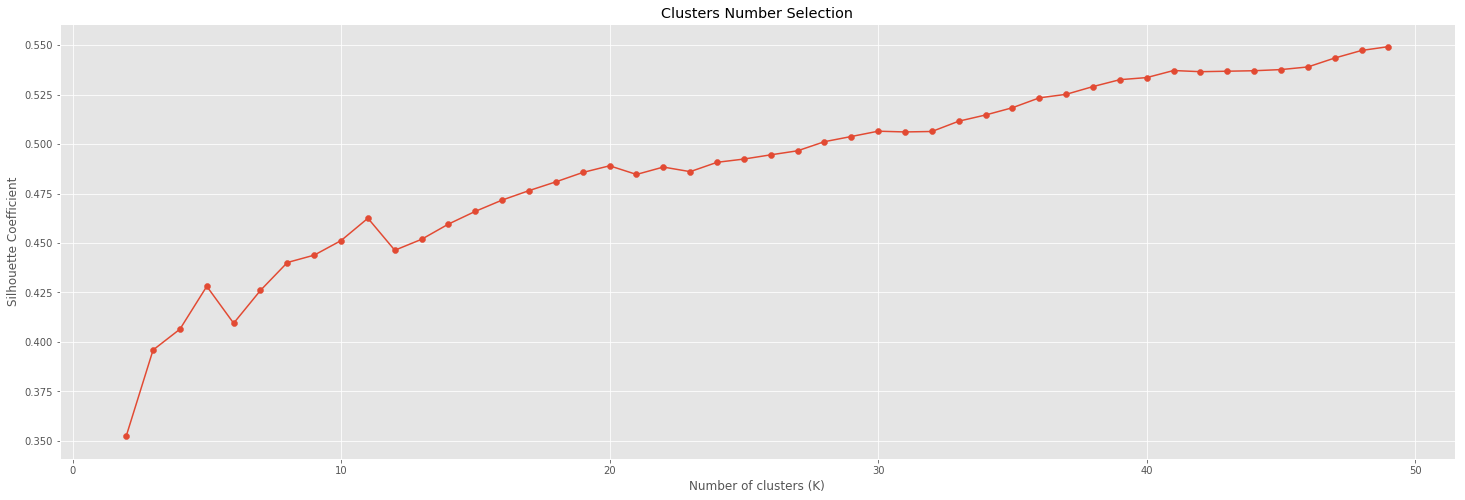

In [22]:
uem.cluster_pattern_vectors(pattern_vectors, n_jobs=-5, pre_dispatch='1.5*n_jobs', temp_folder='tmp')

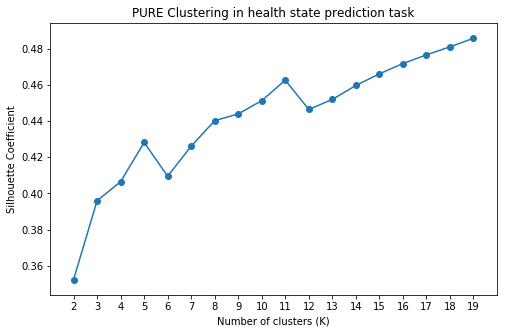

In [10]:
silhouette_avgs = uem.pclust.silhouette_avgs[:18]
ks = range(2, 20)
plt.figure(figsize=(8, 5))
plt.title('PURE Clustering in health state prediction task')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Silhouette Coefficient')
plt.plot(ks, silhouette_avgs)
plt.xticks(ks)
plt.scatter(ks, silhouette_avgs)
plt.show()

_Save user representations..._

In [22]:
result = uem.get_user_representations(exercise_patterns, params={'threshold': 11, 'criterion':'maxclust'})
result.info()

Processing file health_state_prediction/data/output/10003.2016-01.txt :   1%|          | 3/433 [00:00<00:51,  8.42it/s]

No such file or directory: "health_state_prediction/data/output/10003.2016-03.txt"


Processing file health_state_prediction/data/output/10428.2016-07.txt : 100%|██████████| 433/433 [00:43<00:00,  9.97it/s]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 432 entries, 0 to 431
Data columns (total 16 columns):
userID              432 non-null object
time_window         432 non-null object
periodicity_min     432 non-null float64
periodicity_max     432 non-null float64
periodicity_mean    432 non-null float64
cluster_0           432 non-null float64
cluster_1           432 non-null float64
cluster_2           432 non-null float64
cluster_3           432 non-null float64
cluster_4           432 non-null float64
cluster_5           432 non-null float64
cluster_6           432 non-null float64
cluster_7           432 non-null float64
cluster_8           432 non-null float64
cluster_9           432 non-null float64
cluster_10          432 non-null float64
dtypes: float64(14), object(2)
memory usage: 54.1+ KB


In [5]:
result.head(3)

,userID,time_window,periodicity_min,periodicity_max,periodicity_mean,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10
0,10003,2015-11,1.00000,5.0,3.856317,0.000422,0.001659,0.000678,0.001384,0.009694,0.041157,0.012940,0.014144,0.007565,0.000422,0.0
1,10003,2015-12,0.96875,3.1,1.804443,0.005291,0.012301,0.005336,0.016961,0.004192,0.011417,0.144936,0.132760,0.075577,0.005263,0.0
2,10003,2016-01,0.96875,6.2,4.669534,0.000362,0.002503,0.000469,0.001186,0.000355,0.044354,0.019068,0.014143,0.009389,0.000362,0.0


In [5]:
#result = result.fillna(0)
result.to_csv('health_state_prediction/data/exercise_patterns.clusters.train.csv', index=False)

## 4. Save Module

In [6]:
with open('health_state_prediction/saved/PURE.pkl', 'wb') as f:
    pkl.dump(uem, f)

# User Representations

## Load Module

In [2]:
with open('health_state_prediction/saved/PURE.pkl', 'rb') as f:
    uem = pkl.load(f)

## Representation Clusters

### Dendrograms

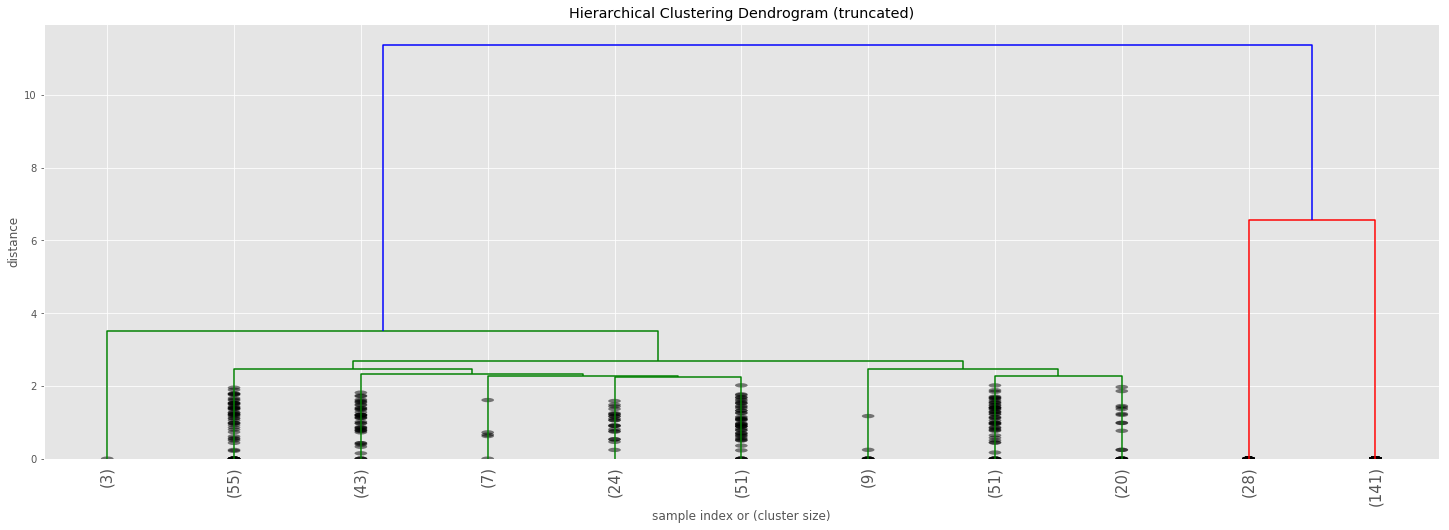

In [27]:
import sys
sys.setrecursionlimit(10000)

uem.pclust.show_dendrogram(p=11)

### Cluster Characteristics

In [26]:
pd.set_option('display.max_colwidth', 500)
uem.show_cluster_chracteristics(threshold=11, criterion='maxclust', n_characteristics=20)

[Cluster 1]	3 periodic user(s)


,pattern,percentage
0,isExercise=(1),100.00


[Cluster 2]	55 periodic user(s)


,pattern,percentage
0,"exerciseClassId=(1.0) & exerciseClassId_and_distance=(exerciseClassId=1.0 AND distance=(-1.156, 57.8])",98.18
1,"exerciseClassId_and_distance=(exerciseClassId=1.0 AND distance=(-1.156, 57.8])",98.18
2,"exerciseClassId_and_duration=(exerciseClassId=1.0 AND duration=(-181.86, 9093.0])",98.18
3,exerciseClassId=(1.0),98.18
4,"exerciseClassId_and_duration=(exerciseClassId=1.0 AND duration=(-181.86, 9093.0]) & exerciseClassId_and_distance=(exerciseClassId=1.0 AND distance=(-1.156, 57.8])",98.18
5,"exerciseClassId=(1.0) & exerciseClassId_and_duration=(exerciseClassId=1.0 AND duration=(-181.86, 9093.0])",87.27
6,"exerciseClassId=(1.0) & exerciseClassId_and_duration=(exerciseClassId=1.0 AND duration=(-181.86, 9093.0]) & exerciseClassId_and_distance=(exerciseClassId=1.0 AND distance=(-1.156, 57.8])",87.27
7,"exerciseClassId_and_duration=(exerciseClassId=1.0 AND duration=(-181.86, 9093.0]) & isExercise=(1)",70.91
8,"exerciseClassId_and_calorie=(exerciseClassId=1.0 AND calorie=(-12.774, 638.7])",67.27
9,exerciseClassId=(1.0) & isExercise=(1),65.45


,pattern,percentage
0,isExercise=(0),90.91


[Cluster 3]	43 periodic user(s)


,pattern,percentage
0,"exerciseClassId_and_distance=(exerciseClassId=4.0 AND distance=(-1.156, 57.8])",100.00
1,exerciseClassId=(4.0),100.00
2,"exerciseClassId=(4.0) & exerciseClassId_and_distance=(exerciseClassId=4.0 AND distance=(-1.156, 57.8])",93.02
3,"exerciseClassId_and_duration=(exerciseClassId=4.0 AND duration=(-181.86, 9093.0]) & exerciseClassId_and_distance=(exerciseClassId=4.0 AND distance=(-1.156, 57.8])",90.70
4,"exerciseClassId_and_duration=(exerciseClassId=4.0 AND duration=(-181.86, 9093.0])",90.70
5,"exerciseClassId_and_calorie=(exerciseClassId=4.0 AND calorie=(-12.774, 638.7])",79.07
6,"exerciseClassId_and_duration=(exerciseClassId=4.0 AND duration=(-181.86, 9093.0]) & isExercise=(1)",74.42
7,"exerciseClassId_and_calorie=(exerciseClassId=4.0 AND calorie=(-12.774, 638.7]) & isExercise=(1)",74.42
8,"exerciseClassId_and_distance=(exerciseClassId=4.0 AND distance=(-1.156, 57.8]) & isExercise=(1)",65.12
9,exerciseClassId=(4.0) & isExercise=(1),58.14


,pattern,percentage
0,isExercise=(0),93.02


[Cluster 4]	7 periodic user(s)


,pattern,percentage
0,isExercise=(0),100.00


,pattern,percentage
0,"exerciseClassId=(8.0) & exerciseClassId_and_distance=(exerciseClassId=8.0 AND distance=(-1.156, 57.8])",42.86
1,exerciseClassId=(8.0),42.86
2,"exerciseClassId_and_distance=(exerciseClassId=8.0 AND distance=(-1.156, 57.8])",42.86
3,"exerciseClassId_and_exerciseTime=(exerciseClassId=8.0 AND exerciseTime=afternoon) & exerciseClassId_and_distance=(exerciseClassId=8.0 AND distance=(-1.156, 57.8])",28.57
4,"exerciseClassId=(8.0) & exerciseClassId_and_distance=(exerciseClassId=8.0 AND distance=(-1.156, 57.8]) & isExercise=(1)",28.57
5,exerciseClassId=(8.0) & isExercise=(1),28.57
6,exerciseClassId_and_exerciseTime=(exerciseClassId=8.0 AND exerciseTime=afternoon),28.57
7,exerciseClassId_and_exerciseTime=(exerciseClassId=8.0 AND exerciseTime=afternoon) & isExercise=(1),28.57
8,"exerciseClassId_and_distance=(exerciseClassId=8.0 AND distance=(-1.156, 57.8]) & isExercise=(1)",28.57
9,exerciseClassId_and_exerciseTime=(exerciseClassId=8.0 AND exerciseTime=afternoon) & exerciseClassId=(8.0),28.57


,pattern,percentage
0,exerciseClassId_and_exerciseTime=(exerciseClassId=13.0 AND exerciseTime=evening) & isExercise=(1),28.57
1,"exerciseClassId=(13.0) & exerciseClassId_and_distance=(exerciseClassId=13.0 AND distance=(-1.156, 57.8])",28.57


[Cluster 5]	24 periodic user(s)


,pattern,percentage
0,"exerciseClassId_and_duration=(exerciseClassId=2.0 AND duration=(-181.86, 9093.0])",100.00
1,exerciseClassId=(2.0),100.00
2,"exerciseClassId_and_distance=(exerciseClassId=2.0 AND distance=(-1.156, 57.8])",100.00
3,"exerciseClassId_and_duration=(exerciseClassId=2.0 AND duration=(-181.86, 9093.0]) & exerciseClassId_and_distance=(exerciseClassId=2.0 AND distance=(-1.156, 57.8])",100.00
4,"exerciseClassId=(2.0) & exerciseClassId_and_distance=(exerciseClassId=2.0 AND distance=(-1.156, 57.8])",95.83
5,"exerciseClassId_and_duration=(exerciseClassId=2.0 AND duration=(-181.86, 9093.0]) & isExercise=(1)",87.50
6,"exerciseClassId_and_duration=(exerciseClassId=2.0 AND duration=(-181.86, 9093.0]) & exerciseClassId_and_distance=(exerciseClassId=2.0 AND distance=(-1.156, 57.8]) & isExercise=(1)",83.33
7,"exerciseClassId_and_distance=(exerciseClassId=2.0 AND distance=(-1.156, 57.8]) & isExercise=(1)",83.33
8,exerciseClassId=(2.0) & isExercise=(1),83.33
9,"exerciseClassId=(2.0) & exerciseClassId_and_distance=(exerciseClassId=2.0 AND distance=(-1.156, 57.8]) & isExercise=(1)",79.17


,pattern,percentage
0,isExercise=(0),79.17


[Cluster 6]	51 periodic user(s)


,pattern,percentage
0,isExercise=(0),58.82


,pattern,percentage
0,"exerciseClassId_and_distance=(exerciseClassId=7.0 AND distance=(-1.156, 57.8])",56.86
1,exerciseClassId=(7.0),56.86
2,"exerciseClassId_and_duration=(exerciseClassId=7.0 AND duration=(-181.86, 9093.0])",56.86
3,"exerciseClassId=(7.0) & exerciseClassId_and_distance=(exerciseClassId=7.0 AND distance=(-1.156, 57.8])",54.90
4,"exerciseClassId_and_duration=(exerciseClassId=7.0 AND duration=(-181.86, 9093.0]) & exerciseClassId_and_distance=(exerciseClassId=7.0 AND distance=(-1.156, 57.8])",54.90
5,"exerciseClassId=(7.0) & exerciseClassId_and_duration=(exerciseClassId=7.0 AND duration=(-181.86, 9093.0])",49.02
6,"exerciseClassId_and_calorie=(exerciseClassId=7.0 AND calorie=(-12.774, 638.7])",49.02
7,"exerciseClassId=(7.0) & exerciseClassId_and_duration=(exerciseClassId=7.0 AND duration=(-181.86, 9093.0]) & exerciseClassId_and_distance=(exerciseClassId=7.0 AND distance=(-1.156, 57.8])",49.02
8,exerciseClassId_and_exerciseTime=(exerciseClassId=7.0 AND exerciseTime=evening),43.14
9,exerciseClassId_and_exerciseTime=(exerciseClassId=7.0 AND exerciseTime=evening) & isExercise=(1),43.14


[Cluster 7]	9 periodic user(s)


,pattern,percentage
0,"exerciseClassId=(9.0) & exerciseClassId_and_duration=(exerciseClassId=9.0 AND duration=(-181.86, 9093.0]) & exerciseClassId_and_distance=(exerciseClassId=9.0 AND distance=(-1.156, 57.8]) & exerciseClassId_and_calorie=(exerciseClassId=9.0 AND calorie=(-12.774, 638.7]) & isExercise=(1)",100.00
1,"exerciseClassId=(9.0) & exerciseClassId_and_duration=(exerciseClassId=9.0 AND duration=(-181.86, 9093.0]) & exerciseClassId_and_distance=(exerciseClassId=9.0 AND distance=(-1.156, 57.8]) & exerciseClassId_and_calorie=(exerciseClassId=9.0 AND calorie=(-12.774, 638.7])",100.00
2,"exerciseClassId=(9.0) & exerciseClassId_and_duration=(exerciseClassId=9.0 AND duration=(-181.86, 9093.0]) & exerciseClassId_and_distance=(exerciseClassId=9.0 AND distance=(-1.156, 57.8]) & isExercise=(1)",100.00
3,"exerciseClassId_and_duration=(exerciseClassId=9.0 AND duration=(-181.86, 9093.0]) & exerciseClassId_and_calorie=(exerciseClassId=9.0 AND calorie=(-12.774, 638.7]) & isExercise=(1)",100.00
4,"exerciseClassId_and_duration=(exerciseClassId=9.0 AND duration=(-181.86, 9093.0]) & exerciseClassId_and_distance=(exerciseClassId=9.0 AND distance=(-1.156, 57.8])",100.00
5,"exerciseClassId=(9.0) & exerciseClassId_and_duration=(exerciseClassId=9.0 AND duration=(-181.86, 9093.0]) & exerciseClassId_and_calorie=(exerciseClassId=9.0 AND calorie=(-12.774, 638.7])",100.00
6,"exerciseClassId_and_calorie=(exerciseClassId=9.0 AND calorie=(-12.774, 638.7])",100.00
7,"exerciseClassId_and_duration=(exerciseClassId=9.0 AND duration=(-181.86, 9093.0]) & exerciseClassId_and_calorie=(exerciseClassId=9.0 AND calorie=(-12.774, 638.7])",100.00
8,"exerciseClassId_and_calorie=(exerciseClassId=9.0 AND calorie=(-12.774, 638.7]) & isExercise=(1)",100.00
9,"exerciseClassId_and_duration=(exerciseClassId=9.0 AND duration=(-181.86, 9093.0]) & exerciseClassId_and_distance=(exerciseClassId=9.0 AND distance=(-1.156, 57.8]) & isExercise=(1)",100.00


[Cluster 8]	51 periodic user(s)


,pattern,percentage
0,"exerciseClassId_and_duration=(exerciseClassId=9.0 AND duration=(-181.86, 9093.0]) & exerciseClassId_and_distance=(exerciseClassId=9.0 AND distance=(-1.156, 57.8])",100.00
1,"exerciseClassId_and_distance=(exerciseClassId=9.0 AND distance=(-1.156, 57.8])",100.00
2,"exerciseClassId_and_duration=(exerciseClassId=9.0 AND duration=(-181.86, 9093.0])",100.00
3,exerciseClassId=(9.0),100.00
4,"exerciseClassId=(9.0) & exerciseClassId_and_distance=(exerciseClassId=9.0 AND distance=(-1.156, 57.8])",100.00
5,"exerciseClassId=(9.0) & exerciseClassId_and_duration=(exerciseClassId=9.0 AND duration=(-181.86, 9093.0])",72.55
6,"exerciseClassId=(9.0) & exerciseClassId_and_duration=(exerciseClassId=9.0 AND duration=(-181.86, 9093.0]) & exerciseClassId_and_distance=(exerciseClassId=9.0 AND distance=(-1.156, 57.8])",72.55
7,"exerciseClassId_and_calorie=(exerciseClassId=9.0 AND calorie=(-12.774, 638.7])",70.59
8,"isExercise=(1) & exerciseClassId=(9.0) & exerciseClassId_and_distance=(exerciseClassId=9.0 AND distance=(-1.156, 57.8])",64.71
9,"isExercise=(1) & exerciseClassId_and_distance=(exerciseClassId=9.0 AND distance=(-1.156, 57.8])",64.71


,pattern,percentage
0,isExercise=(0),78.43


[Cluster 9]	20 periodic user(s)


,pattern,percentage
0,"exerciseClassId_and_duration=(exerciseClassId=9.0 AND duration=(-181.86, 9093.0]) & exerciseClassId_and_distance=(exerciseClassId=9.0 AND distance=(-1.156, 57.8])",100.00
1,"exerciseClassId_and_distance=(exerciseClassId=9.0 AND distance=(-1.156, 57.8])",100.00
2,"exerciseClassId_and_duration=(exerciseClassId=9.0 AND duration=(-181.86, 9093.0])",100.00
3,exerciseClassId=(9.0),100.00
4,"exerciseClassId=(9.0) & exerciseClassId_and_distance=(exerciseClassId=9.0 AND distance=(-1.156, 57.8])",100.00
5,"exerciseClassId_and_calorie=(exerciseClassId=9.0 AND calorie=(-12.774, 638.7])",95.00
6,"exerciseClassId_and_calorie=(exerciseClassId=9.0 AND calorie=(-12.774, 638.7]) & exerciseClassId_and_distance=(exerciseClassId=9.0 AND distance=(-1.156, 57.8])",95.00
7,"exerciseClassId_and_calorie=(exerciseClassId=9.0 AND calorie=(-12.774, 638.7]) & isExercise=(1)",95.00
8,"exerciseClassId_and_calorie=(exerciseClassId=9.0 AND calorie=(-12.774, 638.7]) & exerciseClassId=(9.0) & exerciseClassId_and_distance=(exerciseClassId=9.0 AND distance=(-1.156, 57.8])",95.00
9,"exerciseClassId_and_calorie=(exerciseClassId=9.0 AND calorie=(-12.774, 638.7]) & exerciseClassId=(9.0)",95.00


[Cluster 10]	28 periodic user(s)


,pattern,percentage
0,isExercise=(0),100.00


,pattern,percentage
0,isExercise=(1),100.00
1,isExercise=(0),100.00


[Cluster 11]	141 periodic user(s)


,pattern,percentage
0,isExercise=(0),100.00


,pattern,percentage
0,isExercise=(0),100.00
